
## Clustering Turkish Texts
In this .ipynb file, we will try Word Embeggings instead of TF-IDF or
Sentence Transformers on agglomerative clustering.

Word embedding : Word embedding is a technique that represents words as dense vectors in a continuous vector space based on their semantic meaning.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Exploratory Data Analysis - EDA

In [2]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud

df = pd.read_csv("/content/drive/MyDrive/MLp/data.csv",encoding="utf-8")
print(df.sample(5))

     category                                            content
358   Ekonomi  Ekonomik güven endeksi azaldı Ekonomik güven e...
1109     Spor  2018-19 Kadınlar Ligi, Kadınlar Ligi'nin 13. s...
430   Ekonomi  DETAY  ŞİRKET v MYDAYS İN TÜRKİYE HAYALI Türki...
558   Ekonomi  1950'li yıllara kadar köy ve kent nüfusu oranı...
372   Ekonomi   Türkiye de konutların yüzde 90 ı yalıtmışız  ...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273 entries, 0 to 1272
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  1273 non-null   object
 1   content   1273 non-null   object
dtypes: object(2)
memory usage: 20.0+ KB


In [4]:
print(df.isnull().sum())

category    0
content     0
dtype: int64


In [5]:
print(df["category"].value_counts())

category
Spor             269
Ekonomi          233
Siyasi           212
Kültürel         199
Bilimsel         152
Doğal Afetler    144
Savaşlar          64
Name: count, dtype: int64


#### Visual - Text Lengths and Word Counts

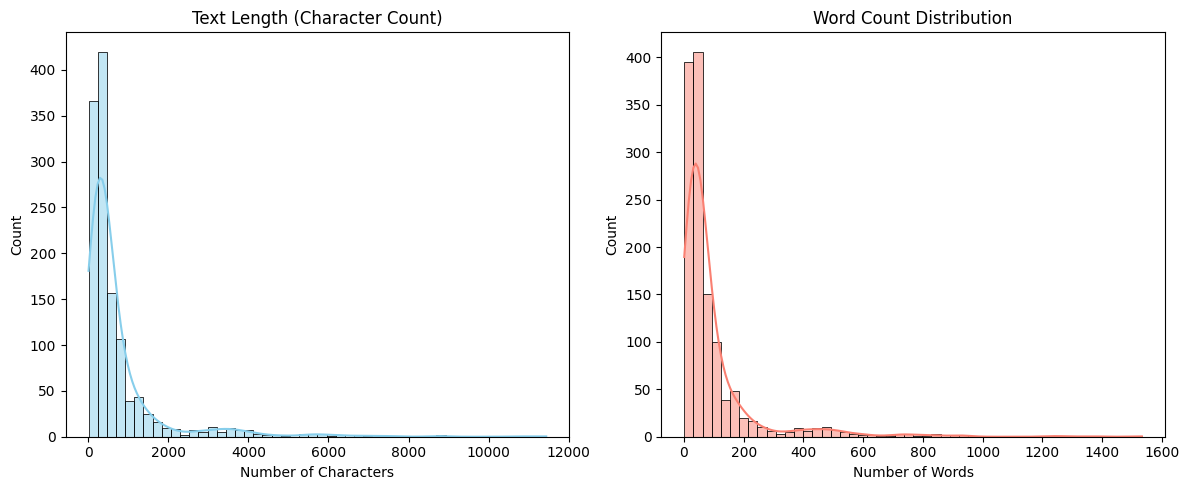

In [6]:
df['text_length'] = df['content'].apply(len)
df['word_count'] = df['content'].apply(lambda x: len(x.split()))

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['text_length'], bins=50, kde=True, color='skyblue')
plt.title('Text Length (Character Count)')
plt.xlabel('Number of Characters')

plt.subplot(1, 2, 2)
sns.histplot(df['word_count'], bins=50, kde=True, color='salmon')
plt.title('Word Count Distribution')
plt.xlabel('Number of Words')

plt.tight_layout()
plt.show()


#### Most common 20 words (with StopWords)

In [7]:
all_words = ' '.join(df['content']).split()
most_common = Counter(all_words).most_common(20)
print(most_common)

[('ve', 3095), ('bir', 1399), ('Türkiye', 902), ('da', 787), ('ile', 762), ('de', 702), ('olarak', 644), ('bu', 599), ('için', 533), ('yüzde', 403), ('olan', 381), ('en', 371), ('Bu', 327), ('ise', 310), ('daha', 307), ('arasında', 302), ('çok', 296), ('yılında', 253), ('büyük', 246), ('tarafından', 242)]


#### Word cloud (with StopWords)

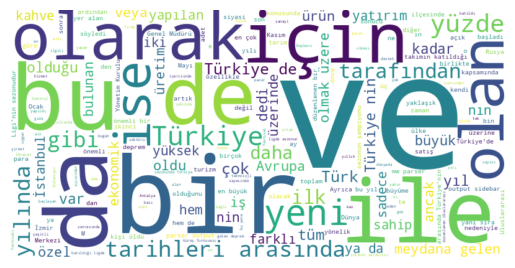

In [8]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['content']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Data Preprocessing

- Lower the text
- Remove pucntuations
- Split
- Stopword Removal
- Stemming using TurkishStemmers

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from snowballstemmer import TurkishStemmer

nltk.download('stopwords')
turkce_stopwords = set(stopwords.words('turkish'))
stemmer = TurkishStemmer()

def preprocessText(text):
    text = text.lower()
    text = re.sub(r'[^\w\sçğıöşü]', '', text)
    words = text.split()
    filtered_words = [word for word in words if word not in turkce_stopwords]
    stemmed_words = [stemmer.stemWord(word) for word in filtered_words if len(word) > 1]
    return ' '.join(stemmed_words)

df["cleanedContent"] = df["content"].apply(preprocessText)
print(df["cleanedContent"][:10])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    rusçukâyanıalemdar mustaf paşaii selimtah tekr...
1    iimahmut sonra tah geçe sultanabdülmecidi kas ...
2    islahat fermanıkır harbi son yıl 28 şubat 1856...
3    ii abdülhamidi tah çıktık sonra 23 aralık 1876...
4    20 ocak 1921 gün 85 sayıl kan millî devlet yan...
5    1924 anayasasıtürk kurtuluş savaş sonra ye iht...
6    195060 dönem son yıllarındaiktidar çoğunluğunu...
7    12 eylül 1980 sabahıtürk silahlı kuvvetleriülk...
8    1982 anayasa kabulü ardı anayasa birçok köklü ...
9    gümrü antlaşmas türk kurtuluş savaş sıra türki...
Name: cleanedContent, dtype: object


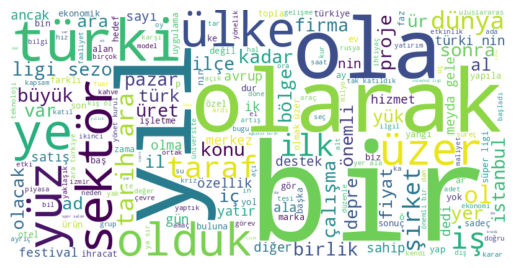

In [10]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleanedContent']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Wrestling in Turkish Culture vs Wrestling in Sports Problem

Since wrestling is in both Cultural and Sports categories, models using word embedding do not perform well. In this section, we will try to deal with this.

In [11]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_sentence_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()   # -> sabit boyutta vektor

text_sport = "2016 Dünya Güreş Olimpiyat Elemeleri Turnuvası 2 6-8 Mayıs 2016 tarihlerinde Türkiye'nin İstanbul kentinde 2016 Yaz Olimpiyatları için dünya çapında düzenlenen iki eleme turnuvalarının ikincisiydi. Bu turnuvadaki yarışmacılar 2015 Dünya Güreş Şampiyonası'nda, kendi bölgesel elemelerinde veya 2016 Dünya Güreş Olimpiyat Elemeleri Turnuvası 1'de Olimpiyatlara katılmaya hak kazanamadı. Her sıklette ilk ikiye giren yarışmacılar kota almaya hak kazanmıştır."

text_culture = "650. Kırkpınar Yağlı Güreşleri 2011 yılında Edirne'de gerçekleşti. 55 başpehlivanın yer aldığı başpehlivanlık mücadelesinde Ali Gürbüz 1. turda Ünal Karaman'ı ikinci turda Savaş Yıldırım'ı 3. turda ise Ali Rıza Kaya'yı çeyrek finalde Osman Aynur'u yarı finalde Fatih Atlı'yı finalde ise Recep Kara'yı yenerek kazandı.[1] Diğer sonuçlar -boy sırasında- şu şekilde gerçekleşti:[1]"

text_sport = preprocessText(text_sport)
text_culture = preprocessText(text_culture)

embedding_sport = get_sentence_embedding(text_sport)
embedding_culture = get_sentence_embedding(text_culture)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity([embedding_sport], [embedding_culture])[0][0]
print("Benzerlik:", similarity)


Benzerlik: 0.8345164


Because of this high similarity, models confuse on clustering. To fix that, we will fine tune the model based on cultural wrestling words such as "Yağlı Güreş", "Edirne" etc.

!! Due to lack of enough data objects, the model fine tuned with very low number of data, in case of showing the idea is working.

In [13]:
!pip install datasets

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split

model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

kulturel_cumleler = [
    "Kırkpınar, Osmanlı'dan günümüze uzanan en eski geleneksel spor organizasyonudur.",
    "Her yıl Edirne'de düzenlenen yağlı güreşler, halkın büyük ilgisini çeker.",
    "Güreşçilerin vücutlarını zeytinyağıyla yağlaması bu etkinliğin simgesidir.",
    "Başpehlivanlık unvanı, Kırkpınar'daki en prestijli ödüldür.",
    "Kırkpınar, UNESCO tarafından Somut Olmayan Kültürel Miras listesine alınmıştır.",
    "650. Kırkpınar Yağlı Güreşleri 2011 yılında Edirne'de gerçekleşti.",
    "Ali Gürbüz başpehlivanlık mücadelesinde finale çıktı.",
    "Yağlı güreşte zeytinyağı kullanılması geleneksel bir uygulamadır.",
    "Kispet adı verilen özel deri kıyafet güreşçiler tarafından giyilir.",
    "Cazgır adlı sunucular pehlivanları tanıtır."
]

spor_cumleler = [
    "2016 Dünya Güreş Olimpiyat Elemeleri Turnuvası İstanbul'da düzenlendi.",
    "Olimpiyat elemelerinde her sıklette ilk ikiye giren yarışmacılar kota aldı.",
    "Dünya Güreş Şampiyonası'nda Türk sporcular başarılı performans sergiledi.",
    "Güreş Federasyonu yeni müsabaka kurallarını açıkladı.",
    "Serbest güreş kategorisinde milli takım seçmeleri yapıldı.",
    "Grekoromen güreşte teknik puanlama sistemi değişti.",
    "Uluslararası güreş federasyonu yeni ağırlık kategorileri belirledi.",
    "Güreş müsabakalarında doping kontrolleri sıklaştırıldı.",
    "Milli güreşçiler Avrupa Şampiyonası'na hazırlanıyor.",
    "Güreş sporu olimpiyat programında yer alan en eski sporlardan biri."
]

texts = kulturel_cumleler + spor_cumleler
labels = [1] * len(kulturel_cumleler) + [0] * len(spor_cumleler)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

def create_dataset(texts, labels):
    return Dataset.from_dict({
        'text': texts,
        'labels': labels
    })

train_dataset = create_dataset(train_texts, train_labels)
test_dataset = create_dataset(test_texts, test_labels)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/MLp/',
    report_to="none",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    eval_strategy="steps",
    eval_steps=500,
    save_steps=500,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

trainer.train()



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

/tmp/ipython-input-13-3240569538.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss


TrainOutput(global_step=6, training_loss=0.7213375568389893, metrics={'train_runtime': 48.5838, 'train_samples_per_second': 0.988, 'train_steps_per_second': 0.123, 'total_flos': 3157332664320.0, 'train_loss': 0.7213375568389893, 'epoch': 3.0})

In [14]:
model_path = "/content/drive/MyDrive/MLp/checkpoint-6"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)

text_sport = "2016 Dünya Güreş Olimpiyat Elemeleri Turnuvası 2 6-8 Mayıs 2016 tarihlerinde Türkiye'nin İstanbul kentinde 2016 Yaz Olimpiyatları için dünya çapında düzenlenen iki eleme turnuvalarının ikincisiydi. Bu turnuvadaki yarışmacılar 2015 Dünya Güreş Şampiyonası'nda, kendi bölgesel elemelerinde veya 2016 Dünya Güreş Olimpiyat Elemeleri Turnuvası 1'de Olimpiyatlara katılmaya hak kazanamadı. Her sıklette ilk ikiye giren yarışmacılar kota almaya hak kazanmıştır."

text_culture = "650. Kırkpınar Yağlı Güreşleri 2011 yılında Edirne'de gerçekleşti. 55 başpehlivanın yer aldığı başpehlivanlık mücadelesinde Ali Gürbüz 1. turda Ünal Karaman'ı ikinci turda Savaş Yıldırım'ı 3. turda ise Ali Rıza Kaya'yı çeyrek finalde Osman Aynur'u yarı finalde Fatih Atlı'yı finalde ise Recep Kara'yı yenerek kazandı.[1] Diğer sonuçlar -boy sırasında- şu şekilde gerçekleşti: Kırkpınar[1]"

text_sport = preprocessText(text_sport)
text_culture = preprocessText(text_culture)

embedding_sport = get_sentence_embedding(text_sport)
embedding_culture = get_sentence_embedding(text_culture)

similarity = cosine_similarity([embedding_sport], [embedding_culture])[0][0]
print("Benzerlik:", similarity)


Benzerlik: 0.8318807


As a result, fine tuning the model helped a little, but the result is not sufficient due to insufficient data.

However, let's move forward with this fine tuned model.

### Agglomerative Clustering (Hierarchical)

In [15]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

model_path = "/content/drive/MyDrive/MLp/checkpoint-6"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def get_bert_embedding(text_list, tokenizer, model, device, max_length=128):
    embeddings = []
    with torch.no_grad():
        for text in text_list:
            inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:,0,:].squeeze().cpu().numpy()
            embeddings.append(cls_embedding)
    return np.array(embeddings)

texts = df['cleanedContent'].astype(str).tolist()

X = get_bert_embedding(texts, tokenizer, model, device)


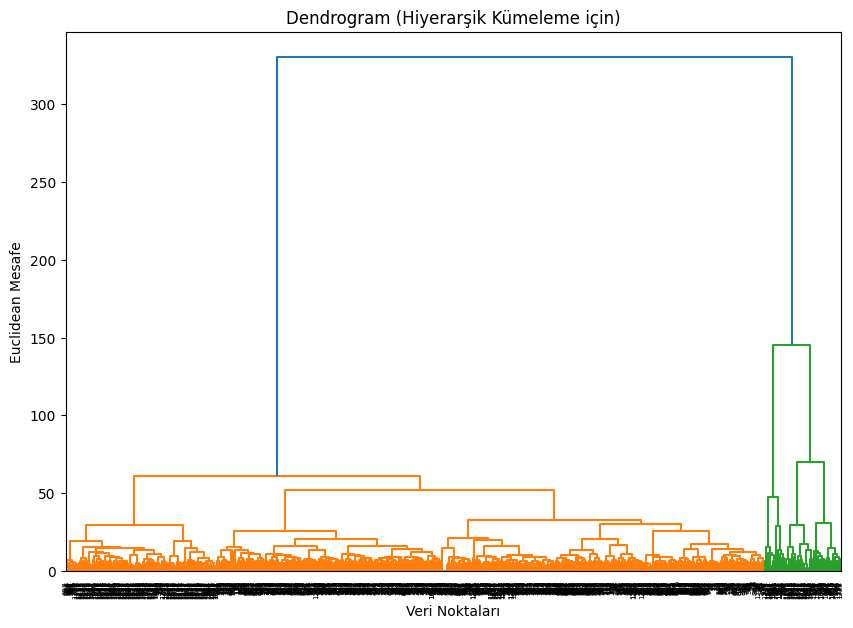

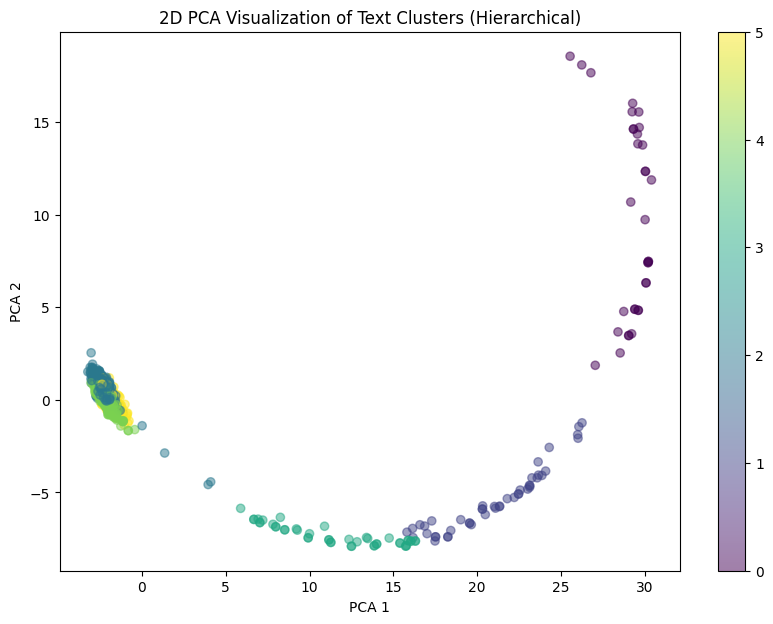

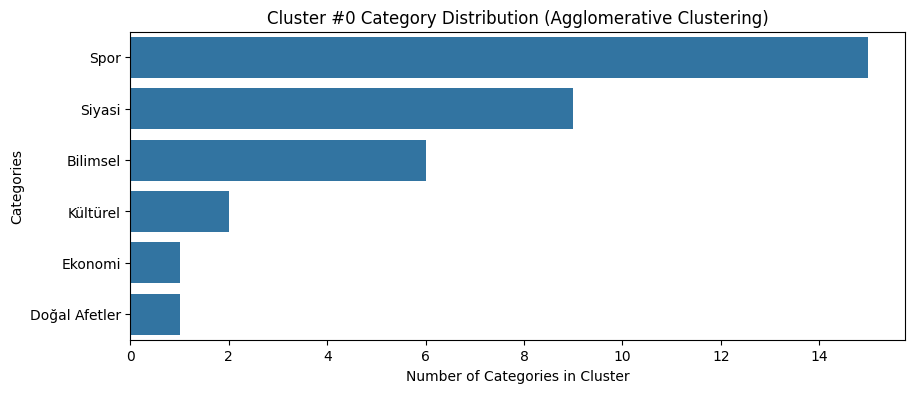

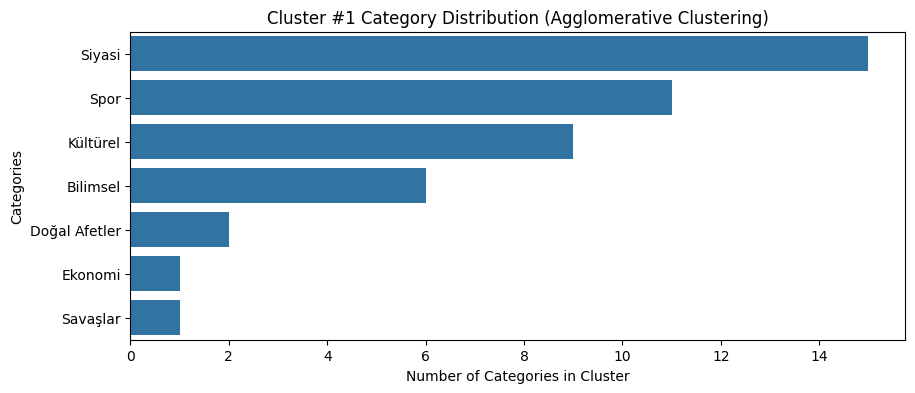

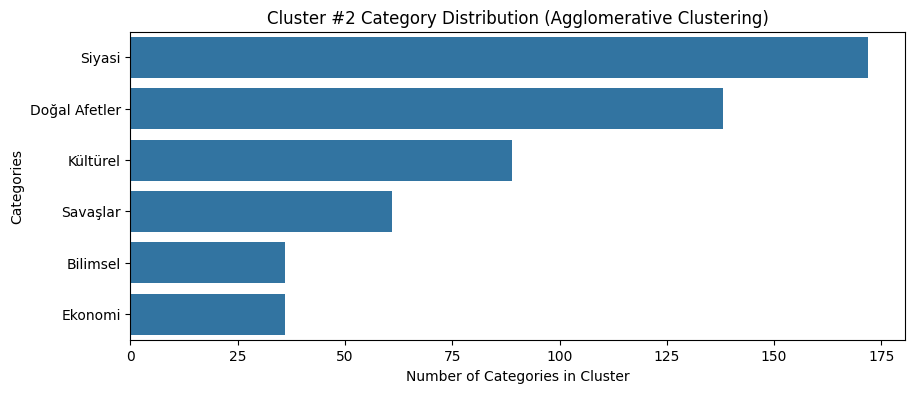

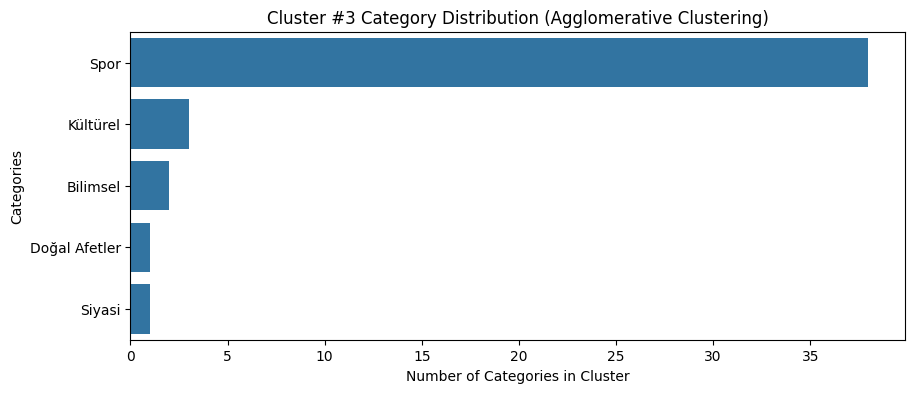

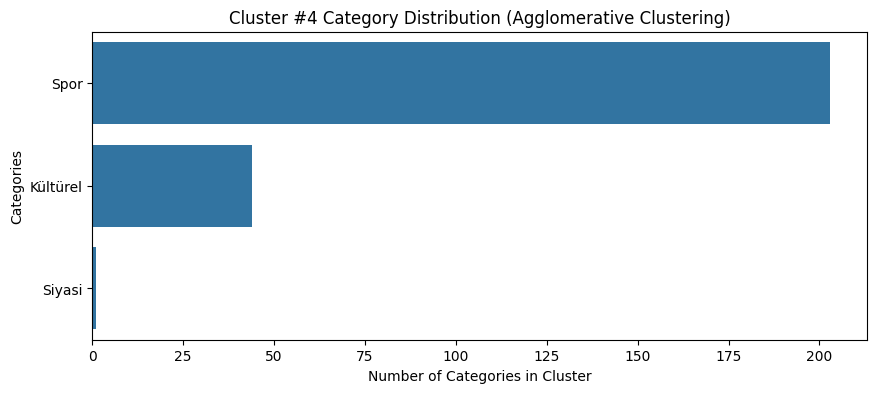

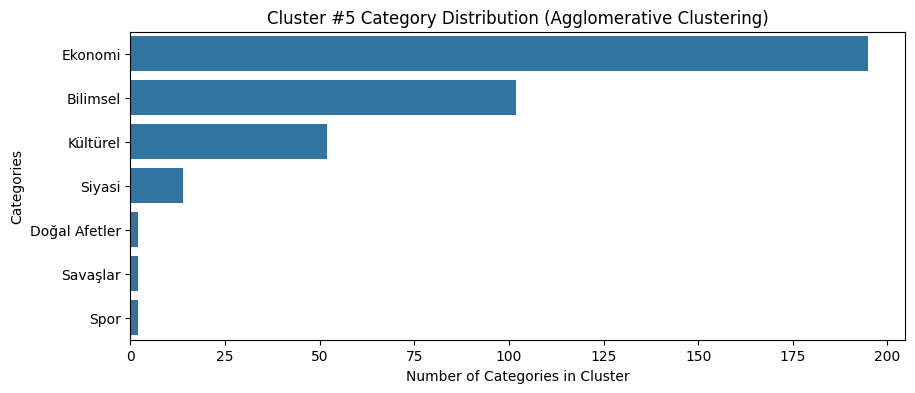

In [23]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import seaborn as sns

plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.title('Dendrogram (Hiyerarşik Kümeleme için)')
plt.xlabel('Veri Noktaları')
plt.ylabel('Euclidean Mesafe')
plt.show()

n_clusters = 6
hc = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
df['cluster'] = hc.fit_predict(X)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
plt.scatter(principal_components[:, 0], principal_components[:, 1],
            c=df['cluster'], cmap='viridis', alpha=0.5)
plt.title('2D PCA Visualization of Text Clusters (Hierarchical)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()


for cluster_num in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster_num]['category']
    plt.figure(figsize=(10,4))
    sns.countplot(y=cluster_data, order=cluster_data.value_counts().index)
    plt.title(f"Cluster #{cluster_num} Category Distribution (Agglomerative Clustering)")
    plt.xlabel("Number of Categories in Cluster")
    plt.ylabel("Categories")
    plt.show()

In [24]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, df['cluster'])
print(f'Silhouette Score: {score:.4f}')

Silhouette Score: 0.1089


In [25]:
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(X, df['cluster'])
print(f'Calinski-Harabasz Index: {ch_score:.4f}')

Calinski-Harabasz Index: 728.5377


In [26]:
from sklearn.metrics import davies_bouldin_score
dbi = davies_bouldin_score(X, df['cluster'])
print(f'Davies-Bouldin Index: {dbi:.4f}')

Davies-Bouldin Index: 2.0197


In [119]:
from joblib import dump, load

dump(hc, '/content/drive/MyDrive/MLp/HC_WE.joblib')

['/content/drive/MyDrive/MLp/HC_WE.joblib']

In [27]:
import json
import os

# --- METRIKLERİN HAZIRLANMASI ---
benchmark_entry = {
    "vectorizer": "BERTurk",
    "cluster_model": "Agglomerative",
    "accuracy": "Unknown",
    "silhouette": float(round(score, 4)),
    "calinski_harabasz": float(round(ch_score, 4)),
    "davies_bouldin": float(round(dbi, 4))
}

# --- DOSYA YOLU BELİRT ---
benchmark_path = "/content/drive/MyDrive/MLp/benchmark.json"

# --- VARSA OKU, YOKSA YENİ OLUŞTUR ---
if os.path.exists(benchmark_path):
    with open(benchmark_path, "r", encoding="utf-8") as f:
        try:
            benchmark_data = json.load(f)
        except json.JSONDecodeError:
            benchmark_data = []
else:
    benchmark_data = []

# --- YENİ VERİYİ EKLE ---
benchmark_data.append(benchmark_entry)

# --- DOSYAYA YAZ ---
with open(benchmark_path, "w", encoding="utf-8") as f:
    json.dump(benchmark_data, f, indent=4, ensure_ascii=False)


### K-Means Clustering

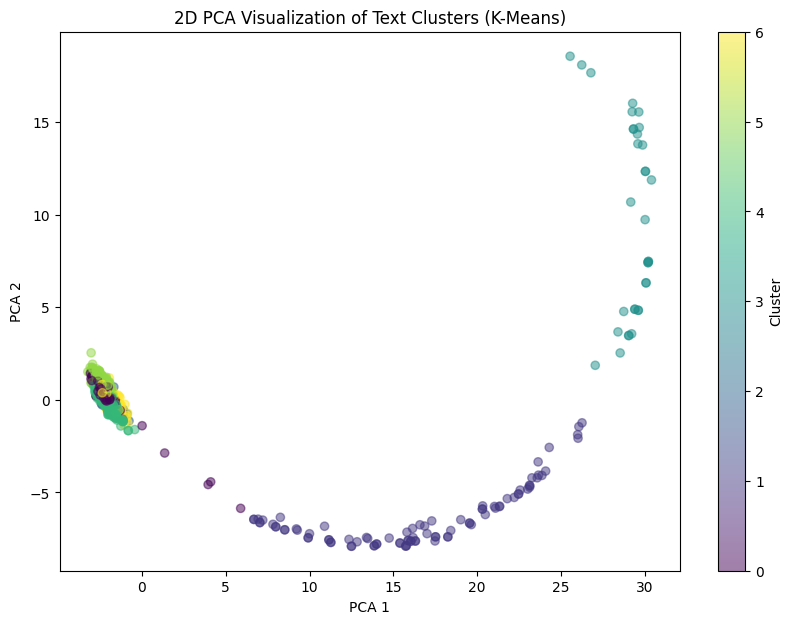

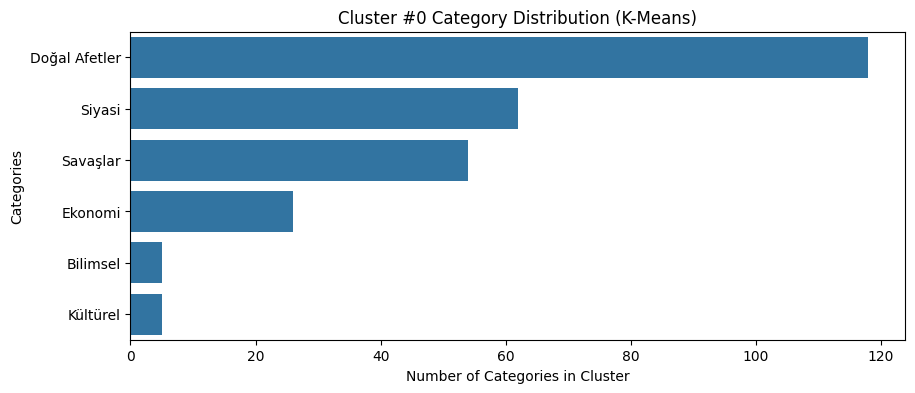

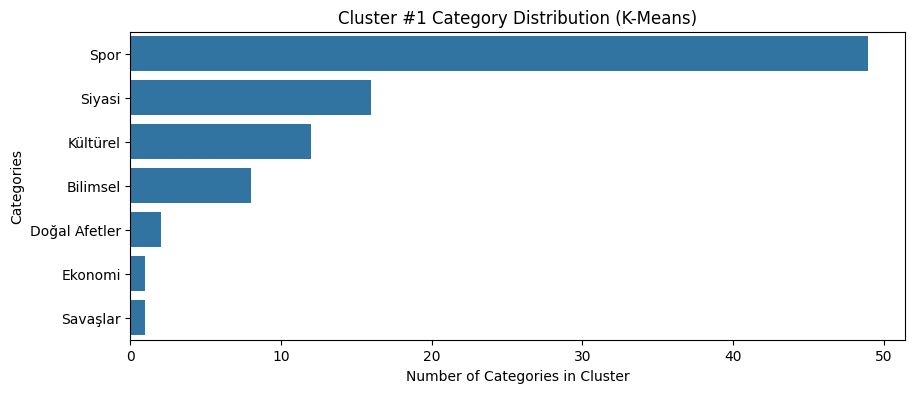

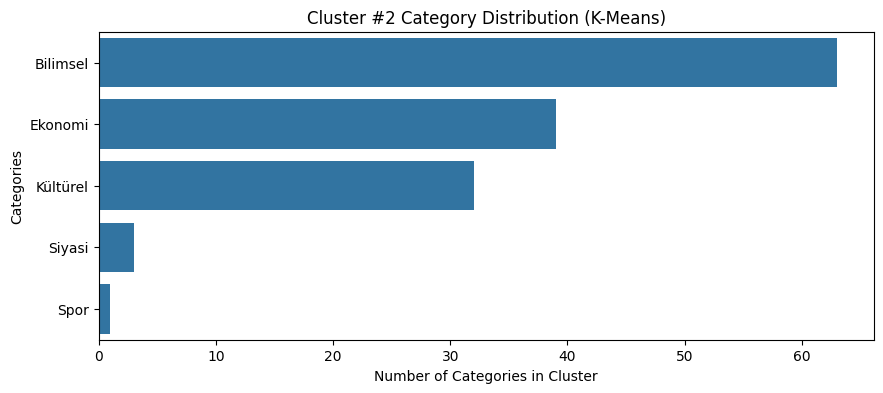

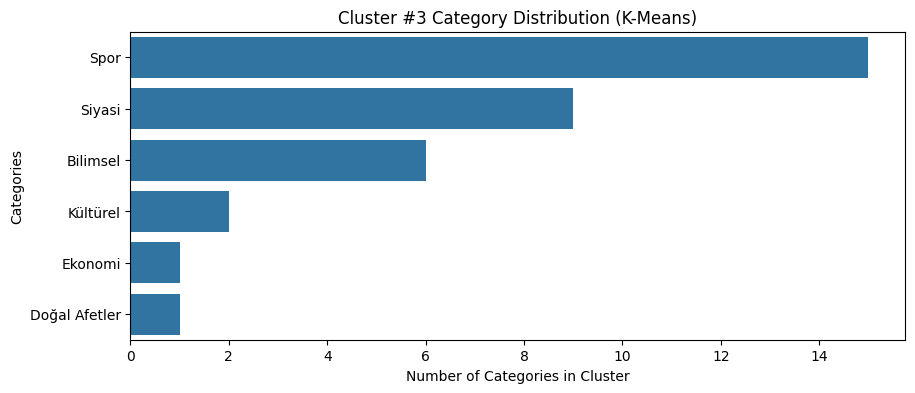

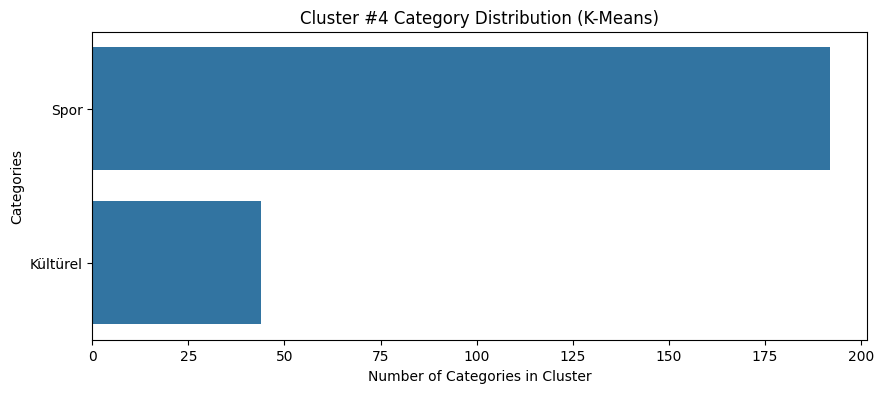

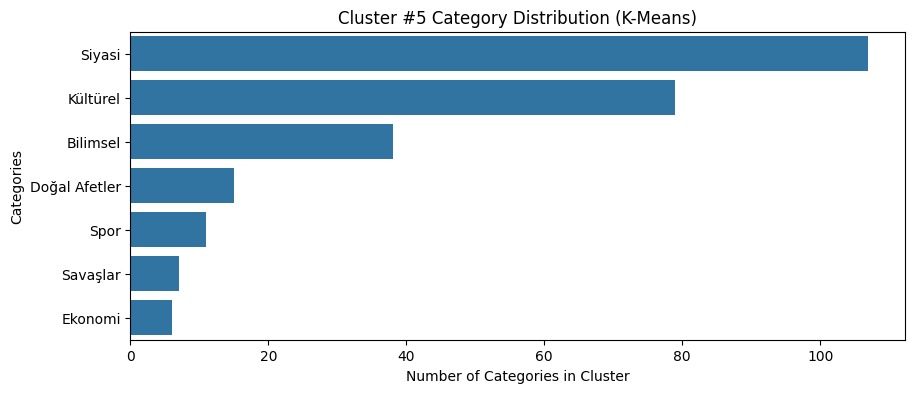

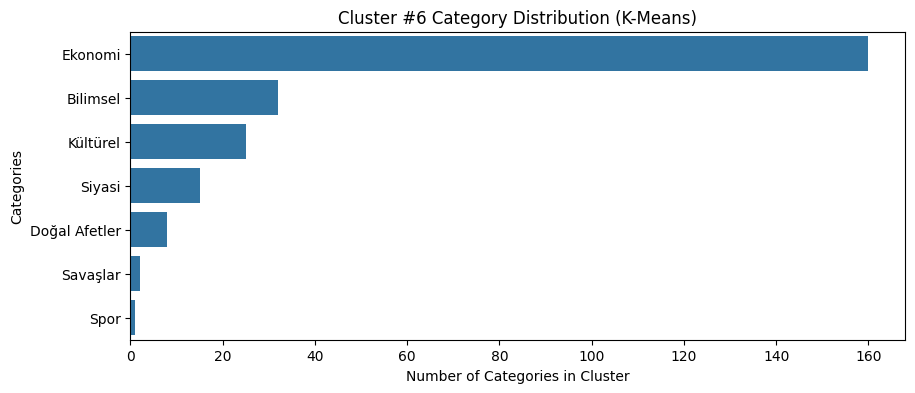

In [28]:
from sklearn.cluster import KMeans

n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
plt.scatter(principal_components[:, 0], principal_components[:, 1],
            c=df['cluster'], cmap='viridis', alpha=0.5)
plt.title('2D PCA Visualization of Text Clusters (K-Means)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

for cluster_num in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster_num]['category']
    plt.figure(figsize=(10,4))
    sns.countplot(y=cluster_data, order=cluster_data.value_counts().index)
    plt.title(f"Cluster #{cluster_num} Category Distribution (K-Means)")
    plt.xlabel("Number of Categories in Cluster")
    plt.ylabel("Categories")
    plt.show()


In [29]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, df['cluster'])
print(f'Silhouette Score: {score:.4f}')

Silhouette Score: 0.1102


In [30]:
from sklearn.metrics import davies_bouldin_score

dbi = davies_bouldin_score(X, df['cluster'])
print(f'Davies-Bouldin Index: {dbi:.4f}')

Davies-Bouldin Index: 2.6172


In [31]:
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(X, df['cluster'])
print(f'Calinski-Harabasz Index: {ch_score:.4f}')

Calinski-Harabasz Index: 570.7341


In [124]:
from joblib import dump, load

dump(kmeans, '/content/drive/MyDrive/MLp/KMeans_WE.joblib')

['/content/drive/MyDrive/MLp/KMeans_WE.joblib']

In [32]:
import json
import os

# --- METRIKLERİN HAZIRLANMASI ---
benchmark_entry = {
    "vectorizer": "BERTurk",
    "cluster_model": "K-Means",
    "accuracy": "Unknown",
    "silhouette": float(round(score, 4)),
    "calinski_harabasz": float(round(ch_score, 4)),
    "davies_bouldin": float(round(dbi, 4))
}

# --- DOSYA YOLU BELİRT ---
benchmark_path = "/content/drive/MyDrive/MLp/benchmark.json"

# --- VARSA OKU, YOKSA YENİ OLUŞTUR ---
if os.path.exists(benchmark_path):
    with open(benchmark_path, "r", encoding="utf-8") as f:
        try:
            benchmark_data = json.load(f)
        except json.JSONDecodeError:
            benchmark_data = []
else:
    benchmark_data = []

# --- YENİ VERİYİ EKLE ---
benchmark_data.append(benchmark_entry)

# --- DOSYAYA YAZ ---
with open(benchmark_path, "w", encoding="utf-8") as f:
    json.dump(benchmark_data, f, indent=4, ensure_ascii=False)


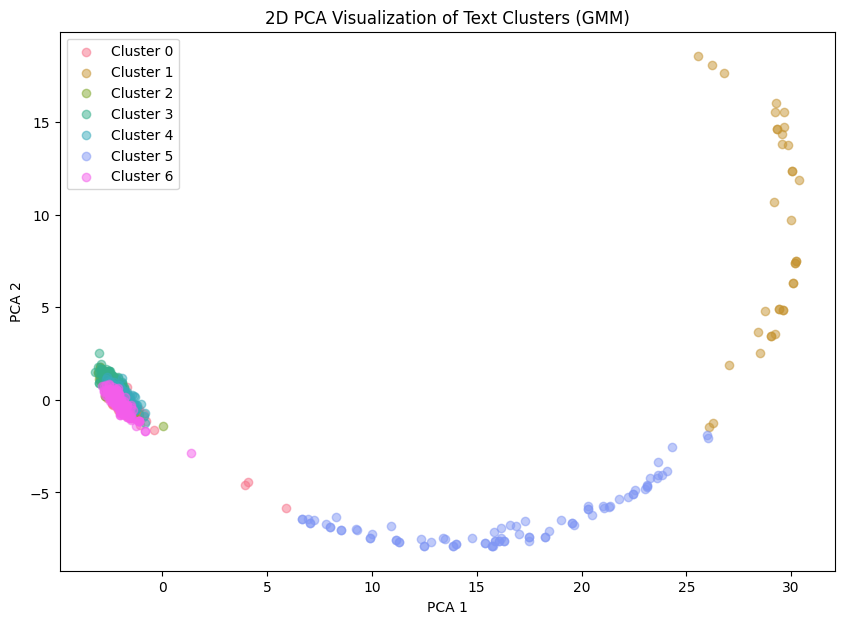

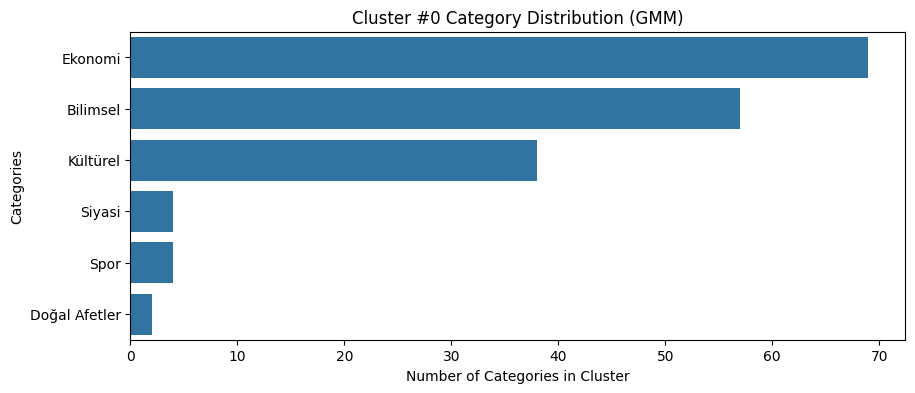

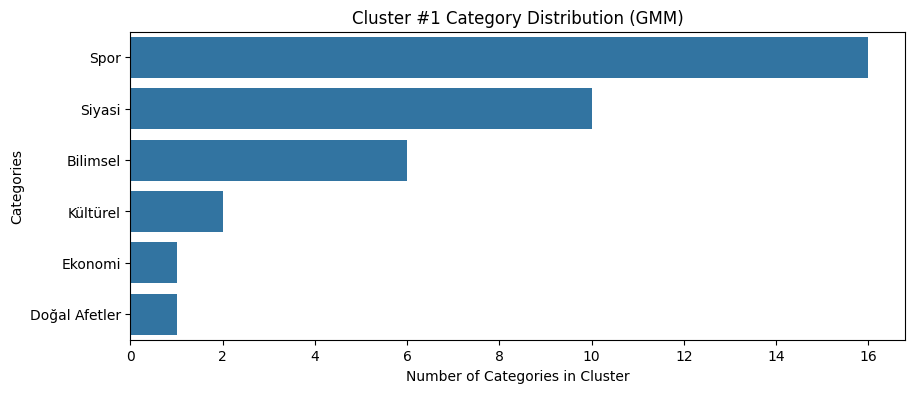

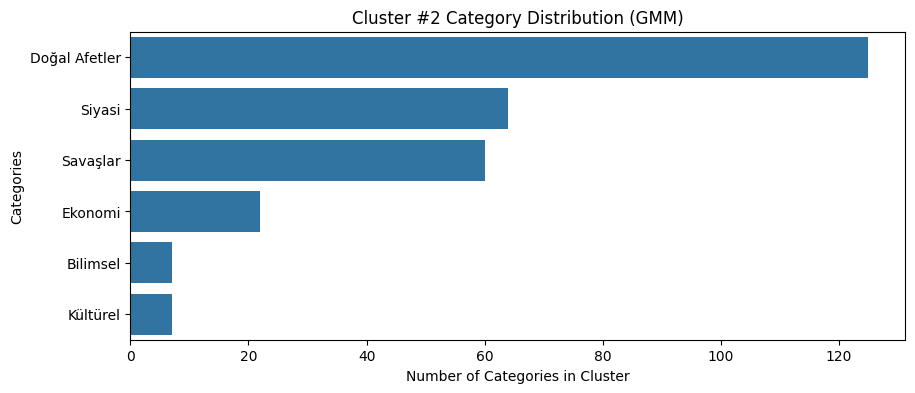

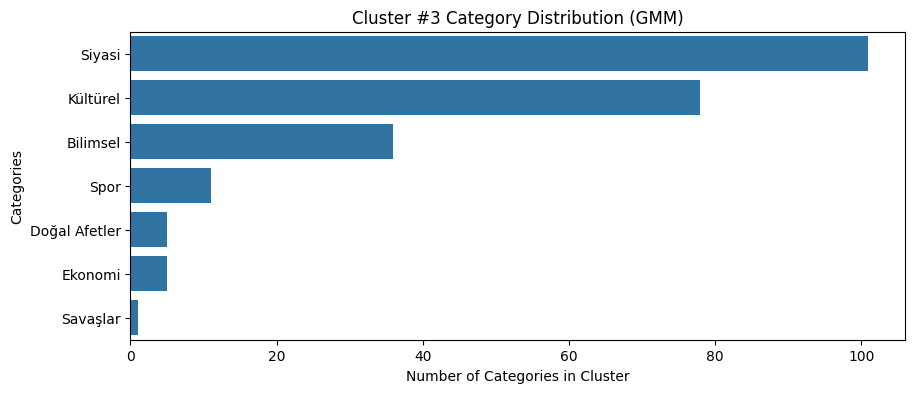

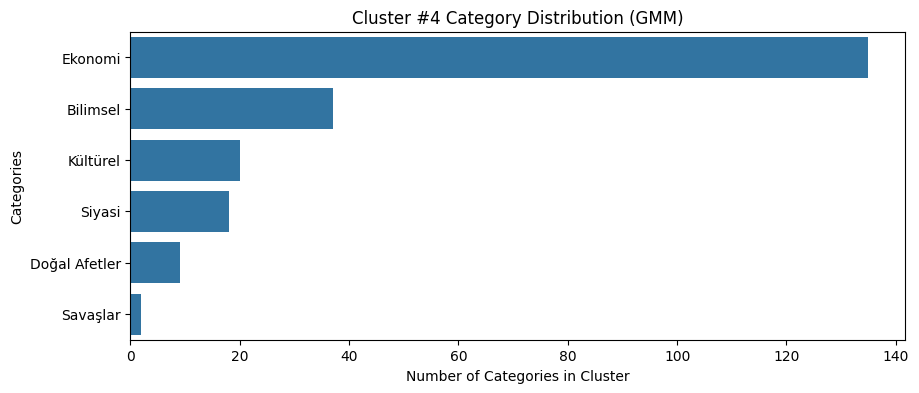

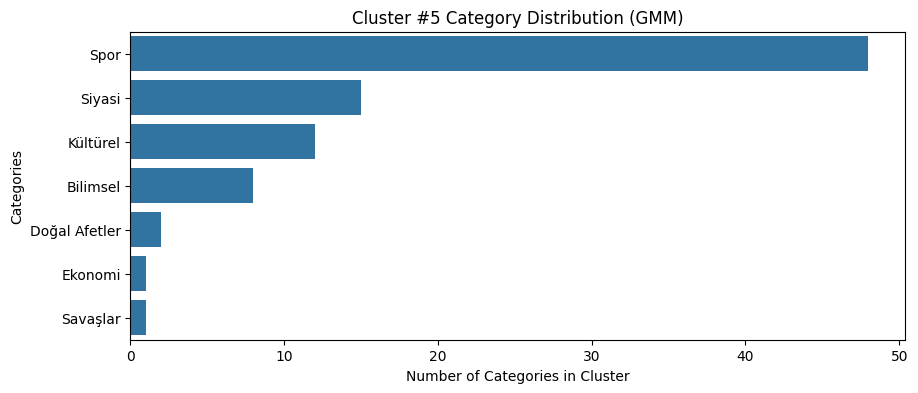

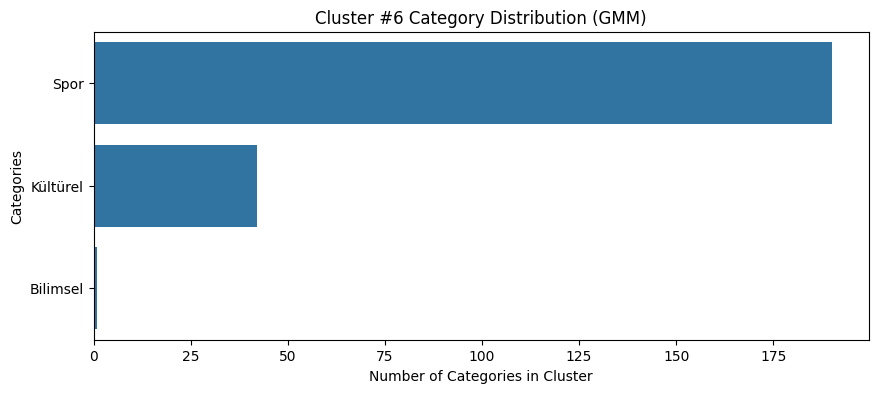

In [33]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

n_clusters = 7

gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42, init_params="kmeans", n_init=10, reg_covar=1e-8)
df['cluster'] = gmm.fit_predict(X)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
colors = sns.color_palette('husl', n_clusters)

for cluster, color in zip(range(n_clusters), colors):
    idx = df['cluster'] == cluster
    plt.scatter(principal_components[idx, 0], principal_components[idx, 1],
                c=[color], label=f'Cluster {cluster}', alpha=0.5)

plt.title('2D PCA Visualization of Text Clusters (GMM)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

for cluster_num in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster_num]['category']
    plt.figure(figsize=(10,4))
    sns.countplot(y=cluster_data, order=cluster_data.value_counts().index)
    plt.title(f"Cluster #{cluster_num} Category Distribution (GMM)")
    plt.xlabel("Number of Categories in Cluster")
    plt.ylabel("Categories")
    plt.show()


In [34]:
score = silhouette_score(X, df['cluster'])
print(f'Silhouette Score: {score:.4f}')

Silhouette Score: 0.1077


In [35]:
dbi = davies_bouldin_score(X, df['cluster'])
print(f'Davies-Bouldin Index: {dbi:.4f}')

Davies-Bouldin Index: 2.6497


In [36]:
ch_score = calinski_harabasz_score(X, df['cluster'])
print(f'Calinski-Harabasz Index: {ch_score:.4f}')

Calinski-Harabasz Index: 571.1708


In [130]:
from joblib import dump, load

dump(gmm, '/content/drive/MyDrive/MLp/GMM_WE.joblib')

['/content/drive/MyDrive/MLp/GMM_WE.joblib']

In [37]:
import json
import os

# --- METRIKLERİN HAZIRLANMASI ---
benchmark_entry = {
    "vectorizer": "BERTurk",
    "cluster_model": "GMM",
    "accuracy": "Unknown",
    "silhouette": float(round(score, 4)),
    "calinski_harabasz": float(round(ch_score, 4)),
    "davies_bouldin": float(round(dbi, 4))
}

# --- DOSYA YOLU BELİRT ---
benchmark_path = "/content/drive/MyDrive/MLp/benchmark.json"

# --- VARSA OKU, YOKSA YENİ OLUŞTUR ---
if os.path.exists(benchmark_path):
    with open(benchmark_path, "r", encoding="utf-8") as f:
        try:
            benchmark_data = json.load(f)
        except json.JSONDecodeError:
            benchmark_data = []
else:
    benchmark_data = []

# --- YENİ VERİYİ EKLE ---
benchmark_data.append(benchmark_entry)

# --- DOSYAYA YAZ ---
with open(benchmark_path, "w", encoding="utf-8") as f:
    json.dump(benchmark_data, f, indent=4, ensure_ascii=False)
